In [1]:
%matplotlib inline
%load_ext memory_profiler

import matplotlib.pyplot as plt

In [2]:
import string
import gzip
import json
import re

In [3]:
import numpy as np
import pandas as pd

In [4]:
import scipy
from scipy import sparse
from scipy import interpolate

In [5]:
import sklearn.cluster
import sklearn.feature_extraction 
import sklearn.feature_extraction.text
import sklearn.metrics
import sklearn.preprocessing

from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [6]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS

[nltk_data] Downloading package stopwords to /home/clb617/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/scratch/clb617/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [7]:
import spacy

nlp = spacy.load('en')

In [8]:
from gensim.models.fasttext import FastText

In [9]:
tweet_id_map = {}
with open("../data/rehydrated_tweets.json", "r") as in_file:
    for line in in_file:
        tweet = json.loads(line)
        tweet_id_map[tweet["id"]] = tweet

In [10]:
tweet_category_map = {}
with open("../data/category_to_tweet_id_training.json", "r") as in_file:
    tweet_category_map = json.load(in_file)

In [11]:
for category, tweet_ids in tweet_category_map.items():
    retrieved_count = sum([1 if int(tid) in tweet_id_map else 0 in tweet_id_map for tid in tweet_ids])
    print("Category:", category)
    print("\tTweet Count:", len(tweet_ids), "Retrieved Fraction:", retrieved_count/len(tweet_ids))
    
    lang_count_map = {}
    for lang in [tweet_id_map[int(tid)]["lang"] for tid in tweet_ids if int(tid) in tweet_id_map]:
        lang_count_map[lang] = lang_count_map.get(lang, 0) + 1
    print("\t", str(lang_count_map))

Category: KnownAlready
	Tweet Count: 113 Retrieved Fraction: 0.9292035398230089
	 {'en': 104, 'ja': 1}
Category: Official
	Tweet Count: 52 Retrieved Fraction: 0.9423076923076923
	 {'en': 48, 'fr': 1}
Category: ContinuingNews
	Tweet Count: 251 Retrieved Fraction: 0.9561752988047809
	 {'en': 237, 'ja': 1, 'tl': 2}
Category: Factoid
	Tweet Count: 140 Retrieved Fraction: 0.9714285714285714
	 {'en': 133, 'tl': 3}
Category: MovePeople
	Tweet Count: 26 Retrieved Fraction: 0.9615384615384616
	 {'en': 25}
Category: Irrelevant
	Tweet Count: 163 Retrieved Fraction: 0.901840490797546
	 {'en': 121, 'und': 1, 'pt': 1, 'in': 1, 'es': 5, 'tl': 17, 'fr': 1}
Category: SignificantEventChange
	Tweet Count: 34 Retrieved Fraction: 0.9705882352941176
	 {'en': 29, 'tl': 4}
Category: Sentiment
	Tweet Count: 132 Retrieved Fraction: 0.9242424242424242
	 {'en': 117, 'tl': 1, 'und': 4}
Category: FirstPartyObservation
	Tweet Count: 28 Retrieved Fraction: 1.0
	 {'en': 28}
Category: ThirdPartyObservation
	Tweet Count

In [12]:
# Skip stop words, retweet signs, @ symbols, and URL headers
stopList = ["http", "https", "rt", "@", ":", "t.co", "co", "amp", "&amp;", "...", "\n", "\r"]
stopList.extend(string.punctuation)

In [13]:
# def tokenizer_wrapper(text):
#     return [t.lemma_ for t in nlp(text)]

local_tokenizer = TweetTokenizer()
def tokenizer_wrapper(text):
    return local_tokenizer.tokenize(text)

In [14]:
# Generate Additional Features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

## Taken from Davidson et al.
def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    tweet_text = tweet["text"]
    
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet_text)
    
    words = local_tokenizer.tokenize(tweet_text) #Get text only
    
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet_text)
    num_terms = len(tweet_text.split())
    num_words = len(words)
    num_unique_terms = len(set([x.lower() for x in words]))
    
    caps_count = sum([1 if x.isupper() else 0 for x in tweet_text])
    caps_ratio = caps_count / num_chars_total
    
    twitter_objs = count_twitter_objs(tweet_text) #Count #, @, and http://
    num_media = 0
    if "media" in tweet["entities"]:
        num_media = len(tweet["entities"]["media"])
    retweet = 0
    if "rt" in words or "retweeted_status" in tweet:
        retweet = 1
        
    has_place = 1 if "coordinates" in tweet else 0
        
    author = tweet["user"]
    is_verified = 1 if author["verified"] else 0
    log_followers = 0 if author["followers_count"] <= 0 else np.log(author["followers_count"])
    log_friends = 0 if author["friends_count"] <= 0 else np.log(author["friends_count"])
    
    features = [num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], 
                sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet, num_media,
                is_verified, 
#                 log_followers, log_friends,
#                 has_place,
                caps_ratio,
               ]

    return features

other_features_names = ["num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos",
                        "vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", 
                        "num_urls", "is_retweet", "num_media",
                        "is_verified", 
#                         "log_followers", "log_friends",
#                         "has_place",
                        "caps_ratio",
                       ]

In [15]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    tokenizer=tokenizer_wrapper,
    ngram_range=(1, 1),
    stop_words=stopList, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=4,
    max_df=0.501
    )

In [16]:
category_to_label = {c:i+1 for i, c in enumerate(tweet_category_map.keys()) if c != "Irrelevant"}
category_to_label["Irrelevant"] = 0

tweet_id_to_category = {}
for category, tweet_ids in tweet_category_map.items():
    if ( len(tweet_ids) < 5 ):
        print("Skipping category:", category)
        continue
        
    for tweet_id in tweet_ids:
        tweet_id_to_category[int(tweet_id)] = category_to_label[category]

Skipping category: CleanUp
Skipping category: Volunteer
Skipping category: Hashtags


In [17]:
category_to_label

{'KnownAlready': 1,
 'Official': 2,
 'ContinuingNews': 3,
 'Factoid': 4,
 'MovePeople': 5,
 'SignificantEventChange': 7,
 'Sentiment': 8,
 'FirstPartyObservation': 9,
 'ThirdPartyObservation': 10,
 'Unknown': 11,
 'MultimediaShare': 12,
 'EmergingThreats': 13,
 'ServiceAvailable': 14,
 'PastNews': 15,
 'Discussion': 16,
 'Advice': 17,
 'InformationWanted': 18,
 'Donations': 19,
 'Weather': 20,
 'CleanUp': 21,
 'Volunteer': 22,
 'Hashtags': 23,
 'Irrelevant': 0}

In [18]:
tweet_pairs = [(tweet, tweet_id_to_category[tid]) 
               for tid, tweet in tweet_id_map.items() if tid in tweet_id_to_category]
tweet_texts_ = [tp[0]["text"] for tp in tweet_pairs]

y_data_ = [tp[1] for tp in tweet_pairs]

In [19]:
other_ftr_data_ = [other_features(tweet) for tweet, _ in tweet_pairs]

In [20]:
%memit

peak memory: 336.41 MiB, increment: 0.21 MiB


In [21]:
tweet_texts_distant = None
other_ftr_data_distant = None

def distant_processor(json_str):
    tweet = json.loads(json_str)
    
    tt = tweet["text"].lower()
    if ( tweet["lang"] == "en" and "walkingdead" not in tt and "iheart" not in tt ):
        return (tweet["text"], other_features(tweet))
    else:
        return None

# with gzip.open("../data/english_2015_sample_1m.json.gz") as in_file:
with gzip.open("../data/tweet_random_subset_2013to2016_disaster.json.gz") as in_file:
    local_tweet_data = [distant_processor(line_bytes.decode("utf8")) for line_bytes in in_file]
    
    tweet_texts_distant = [x[0] for x in local_tweet_data if x != None]
    other_ftr_data_distant = [x[1] for x in local_tweet_data if x != None]
    
print("New tweets:", len(tweet_texts_distant))

New tweets: 732484


In [22]:
%memit

peak memory: 754.95 MiB, increment: 0.05 MiB


In [23]:
# tweet_texts = tweet_texts_ + tweet_texts_distant
# other_ftr_data = np.array(other_ftr_data_ + other_ftr_data_distant)

# y_data = np.array(y_data_ + ([-1] * len(tweet_texts_distant)))

other_ftr_data_main = np.array(other_ftr_data_)
other_ftr_data_spread = np.array(other_ftr_data_distant)

y_data_main = np.array(y_data_)
y_data_spread = np.array(([-1] * len(tweet_texts_distant)))

In [24]:
%memit

peak memory: 855.64 MiB, increment: 0.00 MiB


In [25]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    From: https://www.kaggle.com/mschumacher/using-fasttext-models-for-robust-embeddings
    """
    s = s.lower()

    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', 'zero')
    s = s.replace('1', 'one')
    s = s.replace('2', 'two')
    s = s.replace('3', 'three')
    s = s.replace('4', 'four')
    s = s.replace('5', 'five')
    s = s.replace('6', 'six')
    s = s.replace('7', 'seven')
    s = s.replace('8', 'eight')
    s = s.replace('9', 'nine')

    return s

analyzer = vectorizer.build_analyzer()
def ft_tokenizer(text):
    return [normalize(t) for t in analyzer(text)]

In [26]:
# model_gensim = FastText.load('text_sample_2015_gensim.model')
model_gensim = FastText.load('text_sample_2013to2016_gensim_200.model')
# model_gensim = FastText.load_fasttext_format('../data/cc.en.300.bin')
wvs = model_gensim.wv

In [27]:
wvs.most_similar("prayfourparis")

/scratch/clb617/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('#prayforparis', 0.7739624381065369),
 ('#prayforgaza', 0.674716055393219),
 ('#prayforiraq', 0.6647266149520874),
 ('#prayforsyria', 0.6583042144775391),
 ('#prayforjakarta', 0.6565165519714355),
 ('#prayfororlando', 0.6531145572662354),
 ('#prayforvenezuela', 0.6508985757827759),
 ('#prayforlebanon', 0.6483551263809204),
 ('#prayforpalestine', 0.6478559970855713),
 ('#prayforpalestina', 0.6470707654953003)]

In [28]:
def vectorize(sentence):
    tokenized = [normalize(t) for t in analyzer(sentence)]
    
    wv_vecs = []
    for t in tokenized:

        try:
            v = wvs[t]
            norm = np.linalg.norm(v)
            normed_v = v / norm
            wv_vecs.append(normed_v)
        except:
            continue
    
    m = np.array(wv_vecs)
    normed_m = np.mean(m, axis=0)

    return normed_m

In [29]:
ft_features_main_ = [vectorize(s) for s in tweet_texts_]
ft_features_main = np.array([x for x in ft_features_main_])
print(ft_features_main.shape)

ft_features_spread_ = [vectorize(s) for s in tweet_texts_distant]
ft_features_spread = np.array([x for x in ft_features_spread_])
print(ft_features_spread.shape)

(1253, 200)
(732484, 200)


In [30]:
%memit

peak memory: 6718.43 MiB, increment: 0.18 MiB


In [31]:
print(ft_features_main.shape)
print(ft_features_spread.shape)
print(other_ftr_data_main.shape)
print(other_ftr_data_spread.shape)

(1253, 200)
(732484, 200)
(1253, 16)
(732484, 16)


In [32]:
# X_data = np.concatenate([
#     tfidf, 
#     other_ftr_data, 
# #     pos
# ], axis=1)

X_data_main = np.concatenate([
    ft_features_main, 
    other_ftr_data_main, 
], axis=1)

X_data_spread = np.concatenate([
    ft_features_spread, 
    other_ftr_data_spread, 
], axis=1)

print(X_data_main.shape, y_data_main.shape)
print(X_data_spread.shape, y_data_main.shape)

(1253, 216) (1253,)
(732484, 216) (1253,)


In [33]:
%memit

peak memory: 7925.61 MiB, increment: 0.00 MiB


In [34]:
r_state = 1337
spread_threshold = 0.99

In [ ]:
f1_accum = []
accuracy_accum = []

rf_params = {
    'n_estimators': 128, 
    "n_jobs": -1,
    'random_state': r_state,
    'class_weight': "balanced",
#     'max_depth': 32,
#     'max_features': 113,
#     'min_samples_leaf': 2,
#     'min_samples_split': 54,
}

rs = np.random.RandomState(seed=r_state)
rindex = rs.randint(X_data_spread.shape[0], size=int(X_data_spread.shape[0]/20))

skf = StratifiedKFold(n_splits=10, random_state=r_state)
for train, test in skf.split(X_data_main, y_data_main):

    X_train_ = X_data_main[train]
    y_train_ = y_data_main[train]
    
    X_test = X_data_main[test]
    y_test = y_data_main[test]
    
    print(X_train_.shape, X_data_spread.shape)
    
    # Concatenate training data and label spreading data
    X_train = np.concatenate([
        X_train_,
        X_data_spread[rindex]
    ], axis=0)
    y_train = np.concatenate([y_train_, y_data_spread[rindex]])

    # Use label spreading to expand the training data
    label_spread = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2, n_jobs=-1)
#     label_spread = LabelSpreading(kernel='rbf', gamma=1, alpha=0.2, n_jobs=-1)
    label_spread.fit(X_train, y_train)

    y_data_transdueced = label_spread.transduction_

    label_dist = label_spread.label_distributions_.max(axis=1)
    high_confs = np.argwhere(label_dist >= spread_threshold)[:,0]
    X_data_redux = X_train[high_confs]
    y_data_redux = y_data_transdueced[high_confs]

    print(X_data_redux.shape, y_data_redux.shape)

    # train
    fitted_model = RandomForestClassifier(**rf_params)
    fitted_model.fit(X_data_redux, y_data_redux)

    # Compute Precision-Recall 
    y_infer_local = fitted_model.predict(X_test)
    local_f1 = f1_score(y_test, y_infer_local, average="macro")
    local_score = fitted_model.score(X_test, y_test)
    
    print("\tScore:", local_score)
    print("\tF1:", local_f1)
    
    f1_accum.append(local_f1)
    accuracy_accum.append(local_score)

print("Accuracy:", np.mean(accuracy_accum))
print("F1:", np.mean(f1_accum))

In [35]:
# Concatenate training data and label spreading data
X_train = np.concatenate([
    X_data_main,
    X_data_spread
], axis=0)
print("Merged Size:", X_train.shape)

y_train = np.concatenate([y_data_main, y_data_spread])

# Use label spreading to expand the training data
label_spread = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2, n_jobs=-1)
# label_spread = LabelSpreading(kernel='rbf', gamma=1, alpha=0.2, n_jobs=-1)
label_spread.fit(X_train, y_train)

y_data_transdueced = label_spread.transduction_

Merged Size: (733737, 216)


/scratch/clb617/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: divide by zero encountered in true_divide
  self.label_distributions_ /= normalizer
/scratch/clb617/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


In [36]:
label_dist = label_spread.label_distributions_.max(axis=1)
high_confs = np.argwhere(label_dist >= spread_threshold)[:,0]
print("Total:", high_confs.shape)
print("Added:", high_confs.shape, X_data_main.shape)

X_data_redux = X_train[high_confs]
y_data_redux = y_data_transdueced[high_confs]

/scratch/clb617/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


Total: (108992,)
Added: (108992,) (1253, 216)


In [ ]:
label_dist.mean()

In [ ]:
label_to_category = {j:i for i, j in category_to_label.items()}
for positive_category in category_number_list:
    local_y_data = [1 if y == positive_category else 0 for y in y_data]
    
    fitted_model = RandomForestClassifier(**rf_params)
    fitted_model.fit(X_data, local_y_data)
    
    weights = [(ftr_names_[idx], coef) 
               for idx, coef in enumerate(fitted_model.feature_importances_)]

    tops = sorted(weights, key=lambda x: x[1], reverse=True)[:10]
    
    print("Label:", label_to_category[positive_category])
    print("Score:", fitted_model.score(X_data, local_y_data))
    for token, weight in tops:
        print("\t", token, weight)

In [ ]:
def random_search(X_data, y_data, clf, param_dist, n_iter_search=20, r_state=1337):
    # run randomized search
    random_search = RandomizedSearchCV(clf, 
                                       param_distributions=param_dist,
                                       n_iter=n_iter_search,
                                       cv=10,
                                       scoring="f1_macro",
                                       random_state=r_state,
                                       verbose=2,
                                       n_jobs=-1,
                                      )
    
    random_search.fit(X_data, y_data)

    return (random_search.best_score_, random_search.best_params_)

def model_eval_rf(X_data, y_data, n_iter_search=100, r_state=1337):

    clf = RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=r_state)
    
    # specify parameters and distributions to sample from
    param_dist = {
        "max_depth": [2, 4, 8, 16, 32, 64, 128, None],
        "max_features": scipy.stats.randint(1, 512),
        "min_samples_split": scipy.stats.randint(2, 512),
        "min_samples_leaf": scipy.stats.randint(2, 512),
    }
    
    return random_search(X_data, y_data, clf, param_dist, n_iter_search=n_iter_search, r_state=r_state)

In [ ]:
search_results = model_eval_rf(X_data, y_data, n_iter_search=1024)
search_results

In [ ]:
search_results

In [54]:
from sklearn.manifold import TSNE

# Concatenate training data and label spreading data
X_train = np.concatenate([
    X_data_main,
    #X_data_spread
], axis=0)
y_train = np.concatenate([y_data_main, ])#y_data_spread])

tsne = TSNE(n_components=2, verbose=1, perplexity=100)#, n_iter=300)
X_data_tsne = tsne.fit_transform(X_train[:,:200])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1253 samples in 0.010s...
[t-SNE] Computed neighbors for 1253 samples in 0.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1253
[t-SNE] Computed conditional probabilities for sample 1253 / 1253
[t-SNE] Mean sigma: 0.098389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.732533
[t-SNE] Error after 1000 iterations: 1.099978


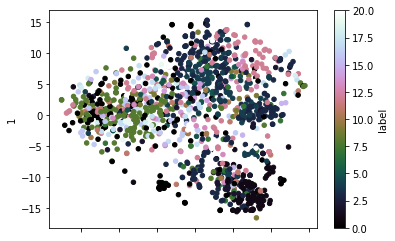

In [55]:
df = pd.DataFrame(X_data_tsne)
df["label"] = y_train
df.plot.scatter(0, 1, c="label", colormap='cubehelix')

In [37]:
# Run Classifier

In [38]:
nb_params = {
    'alpha': 0.29236054513981746,
    'binarize': 0.0024243834476879167,
    'fit_prior': True
}

fitted_model = BernoulliNB(**nb_params)
fitted_model.fit(X_data_redux, y_data_redux)

BernoulliNB(alpha=0.29236054513981746, binarize=0.0024243834476879167,
      class_prior=None, fit_prior=True)

In [39]:
test_tweets = []
with gzip.open("../data/rehydrated_test_tweets.json.gz", "r") as in_file:
    for line_bytes in in_file:
        line = line_bytes.decode("utf8")
        tweet = json.loads(line)
        test_tweets.append(tweet)
        
X_test_ft_ = [vectorize(s) for s in [t["text"] for t in test_tweets]]
X_test_ft_ = np.array([x for x in X_test_ft_])

X_test_other = np.array([other_features(tweet) for tweet in test_tweets])

X_test_data = np.concatenate([
    X_test_ft_, 
    X_test_other, 
], axis=1)

print(X_test_data.shape)

(21617, 216)


In [40]:
y_test_labels = fitted_model.predict(X_test_data)

In [41]:
labeled_test_data = list(zip([t["id"] for t in test_tweets], y_test_labels))

In [42]:
id_to_cat_map = {y:x for x,y in category_to_label.items()}

In [43]:
df = pd.DataFrame([{"tweet_id":tup[0], "label": id_to_cat_map[tup[1]]} for tup in labeled_test_data])
df.groupby("label").count()

,tweet_id
label,
Advice,426
ContinuingNews,13140
Discussion,80
Donations,1713
EmergingThreats,110
Factoid,525
FirstPartyObservation,64
InformationWanted,57
Irrelevant,1594


In [44]:
df.to_csv("trec2018_test_results_run_fasttext_spread.csv", index=None)